In [31]:
import os
import netCDF4 as nc
import pandas as pd
import datetime as datetime
import numpy as  np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import hydromt
from hydromt_wflow.wflow import WflowModel
import xarray as xr
from matplotlib import cm, colors
import matplotlib.patches as mpatches

In [32]:
def readFiles(timestepsecs, coordinate_path,nc_path,nc_name,root_path, refD):
    #%% load netcdf files and create dataframe with coordinates for plotting
    coordinates = pd.read_csv(coordinate_path,sep=';')
    nc_file     = os.path.join(nc_path, 'run_default', nc_name) # netcdf file met wflow output
    # mod         = hydromt.WflowModel(root_path , mode='r')
    #-------------MAYOR MODIFICATION---------------------------
    mod         = WflowModel(root_path , mode='r')
    #indicesFunagira = # manually selected coordinate indices of area (TODO: replace by automated script from coordinate array)

    ds          = nc.Dataset(nc_file)
    reference_date = datetime.datetime(int((refD[0:4])), int((refD[4:6])), int((refD[6:8])))  
   # determine start end end dates
    time        = ds['time'][:]  
    startdate  = reference_date + datetime.timedelta(days=time[0])
    enddate    = reference_date + datetime.timedelta(days=time[len(time)-1]) 
    timestep   = timestepsecs + 'S' 
    date_range = pd.date_range(start = startdate, end = enddate, freq = timestep)    

    startDmdu  = time[0]             # start date of simulation with reference to refD
    endDmdu    = time[len(time)-1]   # end date of simulation with reference to refD
    TotalSimTime =   endDmdu - startDmdu

    Ids = pd.DataFrame(data=d)

    # extract coordinates
    lat  = ds['lat'][:] 
    long = ds['lon'][:] 

    cors = []
    # create list of lat long coordinates in vector format: for each lat all long values are written.
    for i in range(len(long)):
        df1 = pd.DataFrame(lat)
        df2 = long[i]
        df2 = pd.DataFrame(np.repeat(df2, len(lat), axis=0))
        frames = [df1, df2]
        data = pd.concat(frames, axis = 1, ignore_index = True)    
        data.reset_index(drop=True, inplace=True)
        cors.append(data)
    final_cors = pd.concat(cors, axis = 0, ignore_index = True)  
    final_cors.rename(columns={0: 'Ycor', 1: 'Xcor'}, inplace=True)
    final_cors = round(final_cors,4) # round coordinates to 4 decimals to match data from QGIS

    return ds, coordinates, Ids, final_cors, long, data, mod, date_range

In [33]:
def getCoordinates(SelectKeyArea, coordinates, final_cors):
    if SelectKeyArea == True:
    #check indices of coordinates for key area(s) of interest
    #loop over coordinates to extract indices of coordinates that area within the key area
        Indices_Key_Area = []
        for x in range(len(coordinates)):
            Cors     = coordinates.loc[x]
            SelectX  = final_cors[final_cors['Xcor'] == round(Cors.long,4)]            
            SelectY  = SelectX[SelectX['Ycor'] == round(Cors.lat,4)]
            Idx      = int(SelectY.index.values.astype(int)[0])
            Indices_Key_Area.append(Idx) # add index to list
        return Indices_Key_Area

In [34]:
def processingData(Processes, SelectKeyArea, Ids, ds,final_cors, Indices_Key_Area, long):

    for i in range(len(Processes)): # loop over number of processes
        process = Processes[i]
        dates = Ids.loc[i]
        start = dates.start # start ID of proces
        end   = dates.end   # end ID of proces

        # extract data of whole catchment
        rw = ds['river_width'][start:end,:,:]   # extract river width
        qr = ds['q_river'][start:end,:,:]   # extract river discharge
        wd = ds['water_depth'][start:end,:,:]    # extract water depth
        fv = qr/(rw*wd) # calculate flow velocity    

        # rw_av = np.median(rw, axis = 0)
        # qr_av = np.median(qr, axis = 0)
        # fv_av = np.median(fv, axis = 0)
        # wd_av = np.median(wd, axis = 0)
            
        # Data_wd = wd_av.data
        # Data_wd = pd.DataFrame(data=Data_wd)
        # Data_qr = qr_av.data
        # Data_qr = pd.DataFrame(data=Data_qr)
        # Data_fv = fv_av.data
        # Data_fv = pd.DataFrame(data=Data_fv)
        # Data_rw = rw_av.data
        # Data_rw = pd.DataFrame(data=Data_rw)

    # add lat long data for funagira model reach per time step
    #-------------MAYOR MODIFICATION---------------------------
    # Initialize empty lists and DataFrames
    data_reach = []
    data_all = []
    funagira_selection_wd = None
    funagira_selection_fv = None
    funagira_selection_q = None

    # Define function to process data for each variable
    def process_variable(variable_data):
        data_reach = []
        for ts in range(end-start):
            data_step = variable_data[ts,:,:]
            data_step = pd.DataFrame(data=data_step)
            data_all = [data_step[i] for i in range(len(long))]
            wd_complete = pd.concat(data_all, axis = 0, ignore_index = True)
            fr = [final_cors, wd_complete]
            data_fr = pd.concat(fr, axis = 1, ignore_index = True)
            data_reach.append(data_fr)
        variable_reach = np.stack(data_reach)
        if SelectKeyArea:
            indices_key_area_array = np.array(Indices_Key_Area)
            funagira_selection_variable = variable_reach[:,indices_key_area_array,:]
            #funagira_selection_variable_1D = funagira_selection_variable[:,:,2].reshape((end-start)*len(Indices_Key_Area), 1)
        else:
            funagira_selection_variable = None
        return funagira_selection_variable, variable_reach

    # Process data for each variable
    Funagira_selection_WD, wd_reach = process_variable(wd)
    Funagira_selection_FV, fv_reach = process_variable(fv)
    Funagira_selection_Q, qr_reach = process_variable(qr)
    #-------------MAYOR MODIFICATION---------------------------
    return Funagira_selection_WD, Funagira_selection_FV, Funagira_selection_Q, wd_reach, fv_reach, qr_reach

 

In [35]:
def processingData2(Processes, SelectKeyArea, Ids, ds,final_cors, Indices_Key_Area, long):

    for i in range(len(Processes)): # loop over number of processes
        process = Processes[i]
        dates = Ids.loc[i]
        start = dates.start # start ID of proces
        end   = dates.end   # end ID of proces
            
        # extract data of whole catchment
        rw = ds['river_width'][start:end,:,:]   # extract river width
        qr = ds['q_river'][start:end,:,:]   # extract river discharge
        wd = ds['water_depth'][start:end,:,:]    # extract water depth
        fv = qr/(rw*wd) # calculate flow velocity    
        

        # rw_av = np.median(rw, axis = 0)
        # qr_av = np.median(qr, axis = 0)
        # fv_av = np.median(fv, axis = 0)
        # wd_av = np.median(wd, axis = 0)
            
        # Data_wd = wd_av.data
        # Data_wd = pd.DataFrame(data=Data_wd)
        # Data_qr = qr_av.data
        # Data_qr = pd.DataFrame(data=Data_qr)
        # Data_fv = fv_av.data
        # Data_fv = pd.DataFrame(data=Data_fv)
        # Data_rw = rw_av.data
        # Data_rw = pd.DataFrame(data=Data_rw)

    # add lat long data for funagira model reach per time step
        data_reach = []
        data_all = []
        for ts in range(end-start):
            data_all = []
            data_step = wd[ts,:,:]
            data_step = pd.DataFrame(data=data_step)
            for i in range(len(long)):
                df3 = pd.DataFrame(data_step[i])
                frames = [df3]
                data = pd.concat(frames, axis = 1, ignore_index = True)    
                data.reset_index(drop=True, inplace=True)
                data_all.append(data)
            wd_complete = pd.concat(data_all, axis = 0, ignore_index = True)     
            fr = [final_cors, wd_complete]
            data_fr = pd.concat(fr, axis = 1, ignore_index = True) 
            data_reach.append(data_fr)
        wd_reach = np.stack(data_reach)
        if SelectKeyArea == True:
            Funagira_selection_WD = wd_reach[:,Indices_Key_Area,:]
            #Funagira_selection_WD_1D = Funagira_selection_WD[:,:,2].reshape((end-start)*len(Indices_Key_Area), 1)

        data_reach = []
        data_all = []
        for ts in range(end-start):
            data_all = []
            data_step = fv[ts,:,:]
            data_step = pd.DataFrame(data=data_step)
            for i in range(len(long)):
                df3 = pd.DataFrame(data_step[i])
                frames = [df3]
                data = pd.concat(frames, axis = 1, ignore_index = True)    
                data.reset_index(drop=True, inplace=True)
                data_all.append(data)
            wd_complete = pd.concat(data_all, axis = 0, ignore_index = True)     
            fr = [final_cors, wd_complete]
            data_fr = pd.concat(fr, axis = 1, ignore_index = True) 
            data_reach.append(data_fr)
        fv_reach = np.stack(data_reach)
        if SelectKeyArea == True:
            Funagira_selection_FV = fv_reach[:,Indices_Key_Area,:]
            #Funagira_selection_FV_1D = Funagira_selection_FV[:,:,2].reshape((end-start)*len(Indices_Key_Area), 1)
    
        data_reach = []
        data_all = []
        for ts in range(end-start):
            data_all = []
            data_step = qr[ts,:,:]
            data_step = pd.DataFrame(data=data_step)
            for i in range(len(long)):
                df3 = pd.DataFrame(data_step[i])
                frames = [df3]
                data = pd.concat(frames, axis = 1, ignore_index = True)    
                data.reset_index(drop=True, inplace=True)
                data_all.append(data)
            wd_complete = pd.concat(data_all, axis = 0, ignore_index = True)     
            fr = [final_cors, wd_complete]
            data_fr = pd.concat(fr, axis = 1, ignore_index = True) 
            data_reach.append(data_fr)
        qr_reach = np.stack(data_reach)
        if SelectKeyArea == True:
            Funagira_selection_Q = qr_reach[:,Indices_Key_Area,:]
            #Funagira_selection_Q_1D = Funagira_selection_Q[:,:,2].reshape((end-start)*len(Indices_Key_Area), 1)    
    
        
    # # add lat long data for whole catchment based on statistics 
    #     data_all = []
    #     for ts in range(end-start):
    #         data_all = []
    #         data_step = wd[ts,:,:]
    #         data_step = pd.DataFrame(data=data_step)
            
    #         for i in range(len(long)):
    #             df3 = pd.DataFrame(data_step[i])
    #             frames = [df3]
    #             data = pd.concat(frames, axis = 1, ignore_index = True)    
    #             data.reset_index(drop=True, inplace=True)
    #             data_all.append(data)
    #         wd_complete = pd.concat(data_all, axis = 0, ignore_index = True)     
    #         fr = [final_cors, wd_complete]
            
    #         wd_complete = np.stack(data_all)
    #         #pd.concat(data_all, axis = 2, ignore_index = True)          
            
    #     data_all = []
    #     for i in range(len(long)):
    #         df3 = pd.DataFrame(Data_qr[i])
    #         frames = [df3]
    #         data = pd.concat(frames, axis = 1, ignore_index = True)    
    #         data.reset_index(drop=True, inplace=True)
    #         data_all.append(data)
    #     qr_complete = pd.concat(data_all, axis = 0, ignore_index = True)     
        
    #     data_all = []
    #     for i in range(len(long)):
    #         df3 = pd.DataFrame(Data_fv[i])
    #         frames = [df3]
    #         data = pd.concat(frames, axis = 1, ignore_index = True)    
    #         data.reset_index(drop=True, inplace=True)
    #         data_all.append(data)
    #     fv_complete = pd.concat(data_all, axis = 0, ignore_index = True) 
        
    #     data_all = []
    #     for i in range(len(long)):
    #         df3 = pd.DataFrame(Data_rw[i])
    #         frames = [df3]
    #         data = pd.concat(frames, axis = 1, ignore_index = True)    
    #         data.reset_index(drop=True, inplace=True)
    #         data_all.append(data)
    #     rw_complete = pd.concat(data_all, axis = 0, ignore_index = True) 
             
    return Funagira_selection_WD, Funagira_selection_FV, Funagira_selection_Q, wd_reach, fv_reach, qr_reach


In [36]:
def getStatistics(Indices_Key_Area, final_cors, Processes, SelectKeyArea, TS_Stats, output, Funagira_selection_WD, Funagira_selection_FV, Funagira_selection_Q, wd_reach, fv_reach, qr_reach):
        for i in range(len(Processes)):
            process = Processes[i]
            if SelectKeyArea == True: # write statistics only of selected area at given coordinates
                # reset indices and select time step to save 
                coords = final_cors.loc[Indices_Key_Area] 
                coords.reset_index(drop=True, inplace = True)
                WD =  pd.DataFrame(Funagira_selection_WD[TS_Stats,:,2])
                WD.reset_index(drop=True, inplace = True)   
                FV =  pd.DataFrame(Funagira_selection_FV[TS_Stats,:,2])
                FV.reset_index(drop=True, inplace = True)  
                Q =  pd.DataFrame(Funagira_selection_Q[TS_Stats,:,2])
                Q.reset_index(drop=True, inplace = True)        
                    
                frames = [coords, WD, FV, Q]
                data = pd.concat(frames, axis = 1, ignore_index = True)   
                data.rename(columns={0: 'X', 1:'Y', 2:'water_depth', 3:'flow_velocity', 4:'discharge'}, inplace=True)
                
                #export data Funagira to CSV file for comparison to Matlab
                nameCSV = 'Data_extent_' + process + '_ts_'+ str(TS_Stats) + '.csv'
                AllDataPath = os.path.join(output, nameCSV)  
                data.to_csv(AllDataPath, sep=';', mode="w", header=True, index=False)    
                
            else: # write statistics for whole model
                # reset indices and select time step to save 
                coords = final_cors 
                coords.reset_index(drop=True, inplace = True)
                WD =  pd.DataFrame(wd_reach[TS_Stats,:,2])
                WD.reset_index(drop=True, inplace = True)   
                FV =  pd.DataFrame(fv_reach[TS_Stats,:,2])
                FV.reset_index(drop=True, inplace = True)  
                Q =  pd.DataFrame(qr_reach[TS_Stats,:,2])
                Q.reset_index(drop=True, inplace = True)           
            
            
                frames = [final_cors, WD,  FV, Q]
                data = pd.concat(frames, axis = 1, ignore_index = True)     
                data.rename(columns={0: 'lat', 1: 'long', 2:'water_depth', 3:'flow_velocity', 4:'discharge',}, inplace=True)
                
                # Export data whole catchment to CSV file to use in e.g. QGIS 
                nameCSV = 'AllData_' + process + '_ts_' + str(TS_Stats) + '.csv'
                AllDataPath = os.path.join(output, nameCSV)  
                data.to_csv(AllDataPath, sep=';', mode="w", header=True, index=False) 
        return data

In [37]:
def plotParameters(mod, Plotting, data, Processes, SelectKeyArea, root_path, output):
        
        for i in range(len(Processes)):
            process = Processes[i]

            if Plotting == True:    
                colNames = list(data.columns)
                for j in range(3): # loop over parameters
                    par = colNames[j+2]
                    data_plot = data.iloc[:,[0,1,j+2]]
                    data_plot = data_plot.replace(0, np.nan)
                    
                    # Plot data for proces    
                    da =mod.staticmaps['wflow_dem'].raster.mask_nodata()
                    da.attrs.update(long_name='elevation', units='m')
                    # read/derive model basin boundary
                    gdf_bas = mod.basins
                    plt.style.use('seaborn-whitegrid') # set nice style
                    # we assume the model maps are in the geographic CRS EPSG:4326
                    proj = ccrs.PlateCarree()
                    # adjust zoomlevel and figure size to your basis size & aspect
                    zoom_level = 10
                    figsize=(10, 8)       
                        
                    # initialize image with geoaxes
                    fig = plt.figure(figsize=figsize)
                    ax = fig.add_subplot(projection=proj)
                    extent = np.array(da.raster.box.buffer(0.02).total_bounds)[[0, 2, 1, 3]]
                    ax.set_extent(extent, crs=proj)
                    
                    # add sat background image
                    ax.add_image(cimgt.QuadtreeTiles(), zoom_level, alpha=0.5)
                    if SelectKeyArea == True:
                        data_plot.plot(x="X", y="Y", kind="scatter", ax = ax, c = par, colormap="Blues", linewidth = 1)
                    else:
                        data_plot.plot(x="long", y="lat", kind="scatter", ax = ax, c = par, colormap="Blues", linewidth = 1)
                    
                    # plot the basin boundary
                    gdf_bas.boundary.plot(ax=ax, color='k', linewidth=0.3)
                    
                    ax.xaxis.set_visible(True)
                    ax.yaxis.set_visible(True)
                    ax.set_ylabel(f"latitude [degree north]")
                    ax.set_xlabel(f"longitude [degree east]")
                    _ = ax.set_title(f"wflow parameter")
                    
                    #  save figure and export data to csv for visualisation in QGIS
                    figname = process + '_' + par
                    figpath = os.path.join(output, figname)
                    plt.savefig(figpath, dpi=225, bbox_inches="tight")

In [38]:
def plotParameters(mod, Plotting, data, Processes, SelectKeyArea, root_path, output):
        
        for i in range(len(Processes)):
            process = Processes[i]

            if Plotting == True:    
                colNames = list(data.columns)
                for j in range(3): # loop over parameters
                    par = colNames[j+2]
                    data_plot = data.iloc[:,[0,1,j+2]]
                    data_plot = data_plot.replace(0, np.nan)
                    
                    # Plot data for proces    
                    da =mod.staticmaps['wflow_dem'].raster.mask_nodata()
                    da.attrs.update(long_name='elevation', units='m')
                    # read/derive model basin boundary
                    gdf_bas = mod.basins
                    plt.style.use('seaborn-whitegrid') # set nice style
                    # we assume the model maps are in the geographic CRS EPSG:4326
                    proj = ccrs.PlateCarree()
                    # adjust zoomlevel and figure size to your basis size & aspect
                    zoom_level = 10
                    figsize=(10, 8)       
                        
                    # initialize image with geoaxes
                    fig = plt.figure(figsize=figsize)
                    ax = fig.add_subplot(projection=proj)
                    extent = np.array(da.raster.box.buffer(0.02).total_bounds)[[0, 2, 1, 3]]
                    ax.set_extent(extent, crs=proj)
                    
                    # add sat background image
                    ax.add_image(cimgt.QuadtreeTiles(), zoom_level, alpha=0.5)
                    if SelectKeyArea == True:
                        data_plot.plot(x="Y", y="X", kind="scatter", ax = ax, c = par, colormap="Blues", linewidth = 0.5)
                    else:
                        data_plot.plot(x="long", y="lat", kind="scatter", ax = ax, c = par, colormap="Blues", linewidth = 0.5)
                    
                    # plot the basin boundary
                    gdf_bas.boundary.plot(ax=ax, color='k', linewidth=0.3)
                    
                    ax.xaxis.set_visible(True)
                    ax.yaxis.set_visible(True)
                    ax.set_ylabel(f"latitude [degree north]")
                    ax.set_xlabel(f"longitude [degree east]")
                    _ = ax.set_title(f"wflow parameter")
                    
                    #  save figure and export data to csv for visualisation in QGIS
                    figname = process + '_' + par
                    figpath = os.path.join(output, figname)
                    plt.savefig(figpath, dpi=225, bbox_inches="tight")

In [39]:
def plotRiver(mod, output):
    #%% Plot DEM with rivers, reservoirs, gauges and lakes
    da =mod.staticmaps['wflow_dem'].raster.mask_nodata()
    da.attrs.update(long_name='elevation', units='m')


    # read/derive river geometries
    gdf_riv = mod.rivers
    # read/derive model basin boundary
    gdf_bas = mod.basins


    plt.style.use('seaborn-whitegrid') # set nice style
    # we assume the model maps are in the geographic CRS EPSG:4326
    proj = ccrs.PlateCarree()
    # adjust zoomlevel and figure size to your basis size & aspect
    zoom_level = 10
    figsize=(10, 8)
    shaded= False # shaded elevation (looks nicer with more pixels (e.g.: larger basins))!


    # initialize image with geoaxes
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(projection=proj)
    extent = np.array(da.raster.box.buffer(0.02).total_bounds)[[0, 2, 1, 3]]
    ax.set_extent(extent, crs=proj)

    # add sat background image
    ax.add_image(cimgt.QuadtreeTiles(), zoom_level, alpha=0.5)

    ## plot elevation\
    # create nice colormap
    vmin, vmax = da.quantile([0.0, 0.98]).compute()
    c_dem = plt.cm.terrain(np.linspace(0.25, 1, 256))
    cmap = colors.LinearSegmentedColormap.from_list("dem", c_dem)
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    kwargs = dict(cmap=cmap, norm=norm)
    # plot 'normal' elevation
    da.plot(transform=proj, ax=ax, zorder=1, cbar_kwargs=dict(aspect=30, shrink=.8), **kwargs)
    # plot elevation with shades
    if shaded:
        ls = colors.LightSource(azdeg=315, altdeg=45)
        dx, dy = da.raster.res
        _rgb = ls.shade(
            da.fillna(0).values,
            norm=kwargs["norm"],
            cmap=kwargs["cmap"],
            blend_mode="soft",
            dx=dx,
            dy=dy,
            vert_exag=200,
        )
        rgb = xr.DataArray(
            dims=("y", "x", "rgb"), data=_rgb, coords=da.raster.coords
        )
        rgb = xr.where(np.isnan(da), np.nan, rgb)
        rgb.plot.imshow(transform=proj, ax=ax, zorder=2)
                    
    # plot rivers with increasing width with stream order
    kwargs = dict()
    for strord in np.unique(gdf_riv['strord']):
        if strord == np.unique(gdf_riv['strord']).max():
            kwargs.update(label='river')
        gdf_riv[gdf_riv['strord']==strord].plot(ax=ax, linewidth=strord/5, color='blue', zorder=3, **kwargs)
    # plot the basin boundary
    gdf_bas.boundary.plot(ax=ax, color='k', linewidth=0.3)
    # plot various vector layers if present
    if 'gauges' in mod.staticgeoms:
        mod.staticgeoms['gauges'].plot(ax=ax, marker='d', markersize=25, facecolor='k', zorder=5, label='gauges')
    patches = [] # manual patches for legend, see https://github.com/geopandas/geopandas/issues/660
    if 'lakes' in mod.staticgeoms:
        kwargs = dict(facecolor='lightblue', edgecolor='lightblue', linewidth=1, label='lakes')
        mod.staticgeoms['lakes'].plot(ax=ax, zorder=4, **kwargs)
        patches.append(mpatches.Patch(**kwargs))
    if 'reservoirs' in mod.staticgeoms:
        kwargs = dict(facecolor='blue', edgecolor='blue', linewidth=1, label='reservoirs')
        mod.staticgeoms['reservoirs'].plot(ax=ax, zorder=4, **kwargs)
        patches.append(mpatches.Patch(**kwargs))
    if 'glaciers' in mod.staticgeoms:
        kwargs = dict(facecolor='grey', edgecolor='grey', linewidth=1, label='glaciers')
        mod.staticgeoms['glaciers'].plot(ax=ax, zorder=4, **kwargs)
        patches.append(mpatches.Patch(**kwargs))
        
    ax.xaxis.set_visible(True)
    ax.yaxis.set_visible(True)
    ax.set_ylabel(f"latitude [degree north]")
    ax.set_xlabel(f"longitude [degree east]")
    _ = ax.set_title(f"wflow base map")
    legend = ax.legend(
        handles=[*ax.get_legend_handles_labels()[0], *patches],
        title="Legend",
        loc='lower right',
        frameon=True,
        framealpha=0.7,
        edgecolor='k',
        facecolor='white'
    )

    # save figure
    figname = "basemap.png"
    figpath = os.path.join(output, figname)
    plt.savefig(figpath, dpi=225, bbox_inches="tight")

In [40]:
def plotParameters2(mod, Plotting, data, Processes, SelectKeyArea, root_path, output):
        
        for i in range(len(Processes)):
            process = Processes[i]

            if Plotting == True:    
                colNames = list(data.columns)
                for j in range(3): # loop over parameters
                    par = colNames[j+2]
                    data_plot = data.iloc[:,[0,1,j+2]]
                    data_plot = data_plot.replace(0, np.nan)

                    data_plot.plot(x="X", y="Y", kind="scatter", c = par, colormap="Blues", linewidth = 100)

In [41]:
def plorTemperature(root_path,nc_path, SelectTS, mod, date_range, output):

    #%% plot other static maps

    nc_file = os.path.join(root_path, 'inmaps-chirps-2010.nc') # file with temperature and precipitation
    nc_file2  = os.path.join(nc_path, 'staticmaps.nc') # netcdf file met wflow output


    # load and write parameters to plot in static data
    ds = nc.Dataset(nc_file)
    print(ds)
    print(ds.__dict__)
    for dim in ds.dimensions.values():
        print(dim)
    for var in ds.variables.values():
        print(var) 

    lat = ds['x'][:] 
    long = ds['y'][:] 

    #temp = ds['temp'][210,:,:]
    # testing load nc file
    #ds = nc.Dataset(era5_fn)
    #print(ds)

    cors = []
    # create list of lat long coordinates in vector format
    for i in range(len(long)):
        df1 = pd.DataFrame(lat)
        df2 = long[i]
        df2 = pd.DataFrame(np.repeat(df2, len(lat), axis=0))
        frames = [df1, df2]
        data = pd.concat(frames, axis = 1, ignore_index = True)    
        data.reset_index(drop=True, inplace=True)
        cors.append(data)
    final_cors = pd.concat(cors, axis = 0, ignore_index = True)  
    final_cors.rename(columns={0: 'lat', 1: 'long'}, inplace=True)


    


    #%% Plot static data

    #plot graph temperature
    temp = ds['temp'][SelectTS,:,:]

    data_all = []
    for i in range(len(long)):
        df3 = pd.DataFrame(temp[i])
        frames = [df3]
        data = pd.concat(frames, axis = 1, ignore_index = True)    
        data.reset_index(drop=True, inplace=True)
        data_all.append(data)
    rain_complete = pd.concat(data_all, axis = 0, ignore_index = True) 

    frames = [final_cors, rain_complete]
    data = pd.concat(frames, axis = 1, ignore_index = True)     
    data.rename(columns={0: 'lat', 1: 'long', 2:'Temperature'}, inplace=True)


    # Plot data for proces    
    da =mod.staticmaps['wflow_dem'].raster.mask_nodata()
    da.attrs.update(long_name='elevation', units='m')
    # read/derive model basin boundary
    gdf_bas = mod.basins
    plt.style.use('seaborn-whitegrid') # set nice style
    # we assume the model maps are in the geographic CRS EPSG:4326
    proj = ccrs.PlateCarree()
    # adjust zoomlevel and figure size to your basis size & aspect
    zoom_level = 10
    figsize=(10, 8)       
        
    # initialize image with geoaxes
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(projection=proj)
    extent = np.array(da.raster.box.buffer(0.02).total_bounds)[[0, 2, 1, 3]]
    ax.set_extent(extent, crs=proj)

    # add sat background image
    ax.add_image(cimgt.QuadtreeTiles(), zoom_level, alpha=0.5)

    data.plot(x="lat", y="long", kind="scatter", ax = ax, c = 'Temperature', colormap='YlOrRd', linewidth = 0.1)

    # plot the basin boundary
    gdf_bas.boundary.plot(ax=ax, color='k', linewidth=0.3)

    sel_date = str(date_range[SelectTS])
    _ = ax.set_title(sel_date)

    figname = "Temperature"+ '_ts_' + str(SelectTS) + '.png'
    figpath = os.path.join(output, figname)
    plt.savefig(figpath, dpi=225, bbox_inches="tight")

    return ds, SelectTS, final_cors, mod, output, long 


In [42]:
def plotPrecipitation(ds, SelectTS, final_cors, mod, output, long):

    #%% plot graph precipiation

    rain = ds['precip'][SelectTS,:,:]

    data_all = []
    for i in range(len(long)):
        df3 = pd.DataFrame(rain[i])
        frames = [df3]
        data = pd.concat(frames, axis = 1, ignore_index = True)    
        data.reset_index(drop=True, inplace=True)
        data_all.append(data)
    rain_complete = pd.concat(data_all, axis = 0, ignore_index = True) 

    frames = [final_cors, rain_complete]
    data = pd.concat(frames, axis = 1, ignore_index = True)     
    data.rename(columns={0: 'lat', 1: 'long', 2:'Precipitation'}, inplace=True)


    # Plot data for proces    
    da =mod.staticmaps['wflow_dem'].raster.mask_nodata()
    da.attrs.update(long_name='elevation', units='m')
    # read/derive model basin boundary
    gdf_bas = mod.basins
    plt.style.use('seaborn-whitegrid') # set nice style
    # we assume the model maps are in the geographic CRS EPSG:4326
    proj = ccrs.PlateCarree()
    # adjust zoomlevel and figure size to your basis size & aspect
    zoom_level = 10
    figsize=(10, 8)       
        
    # initialize image with geoaxes
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(projection=proj)
    extent = np.array(da.raster.box.buffer(0.02).total_bounds)[[0, 2, 1, 3]]
    ax.set_extent(extent, crs=proj)

    # add sat background image
    ax.add_image(cimgt.QuadtreeTiles(), zoom_level, alpha=0.5)
    data.plot(x="lat", y="long", kind="scatter", ax = ax, c = 'Precipitation', colormap="YlGnBu", linewidth = 0.1)

    # plot the basin boundary
    gdf_bas.boundary.plot(ax=ax, color='k', linewidth=0.3)


    figname = "Precipitation"+ '_ts_' + str(SelectTS) + '.png'
    figpath = os.path.join(output, figname)
    plt.savefig(figpath, dpi=225, bbox_inches="tight")


In [43]:
nc_path = r"N:\Projects\11208000\11208005\F. Other information\025- EFlows\Manual\Tutorial files\wflow_model_updated"
root_path = r"N:\Projects\11208000\11208005\F. Other information\025- EFlows\Manual\Tutorial files\wflow_model_updated"
nc_name = 'output.nc'
output = r"output2"    # folder to write output files and figures
coordinate_path =  r"N:\Projects\11208000\11208005\F. Other information\025- EFlows\Manual\Coordinates.csv"                      # list with coordinates to extract extent of model (if SelectKeyArea = True)
                                                          #[4966, 4967, 4968, 4969, 5149, 5153, 5330, 5331, 5332]

Plotting = True             # if false, no plots are created
SelectKeyArea = True        # if true, a set of coordinates has to be given from which the data is extracted. If false, the whole catchment is considered.

# specify wflow time input
timestepsecs = '86400'      # timestep in seconds. given in *.toml file
refD         = '19000101'   # reference date . given in *.toml file
TS_Stats     = 10           # user defined timestep to extract results for discharge, flow velocity and water depth On Day interval?
SelectTS     = 303          # user defined timestep for extracting results in static maps

# select the periods where you want to extract the data
Processes    = ['year2009']        # name of processes you want to extract
d = {'start': [122], 'end': [486]} #start dates and end dates within one process, see date_range for dates and corresponding index


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    unit: mm
    precip_fn: era5
    dimensions(sizes): time(731), y(183), x(96)
    variables(dimensions): int64 time(time), float64 y(y), float64 x(x), int32 spatial_ref(), float32 precip(time, y, x), int32 idx_out(y, x), uint8 mask(y, x), float32 pet(time, y, x), float32 temp(time, y, x)
    groups: 
{'unit': 'mm', 'precip_fn': 'era5'}
<class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 731
<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 183
<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 96
<class 'netCDF4._netCDF4.Variable'>
int64 time(time)
    units: days since 2008-09-01 00:00:00
    calendar: proleptic_gregorian
unlimited dimensions: 
current shape = (731,)
filling on, default _FillValue of -9223372036854775806 used
<class 'netCDF4._netCDF4.Variable'>
float64 y(y)
    _FillValue: nan
unlimited dimensions: 
current shape = (183,)
filling on
<class 'netCDF4._netCDF4.Va

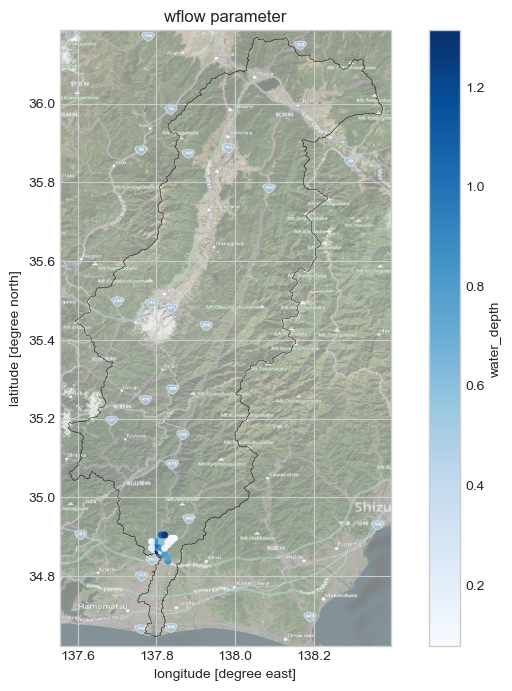

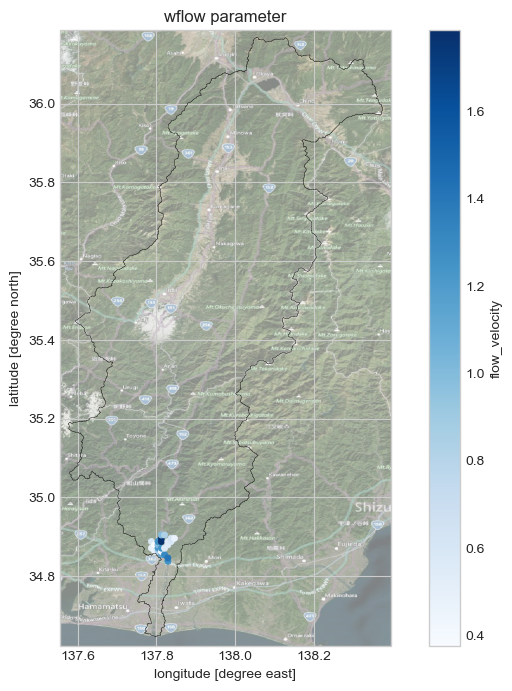

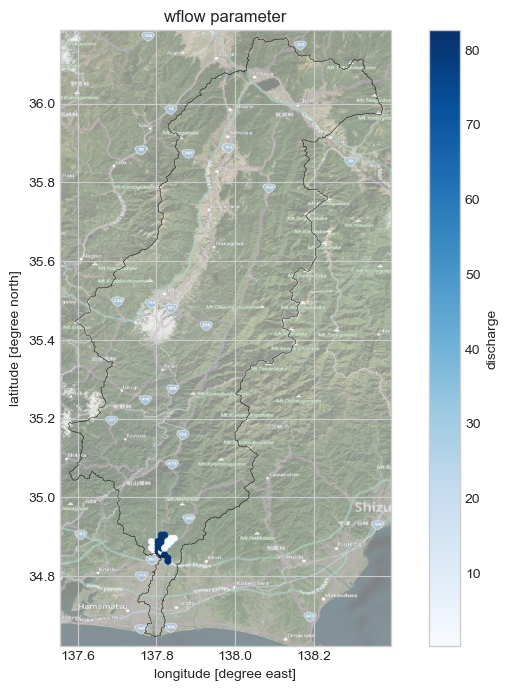

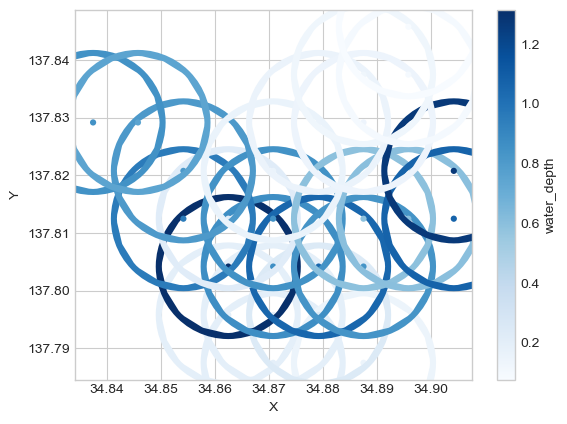

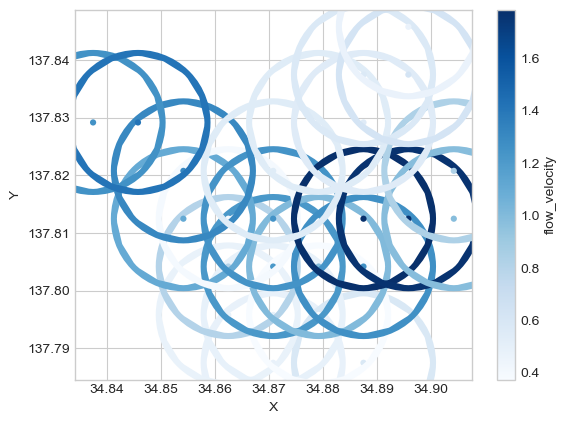

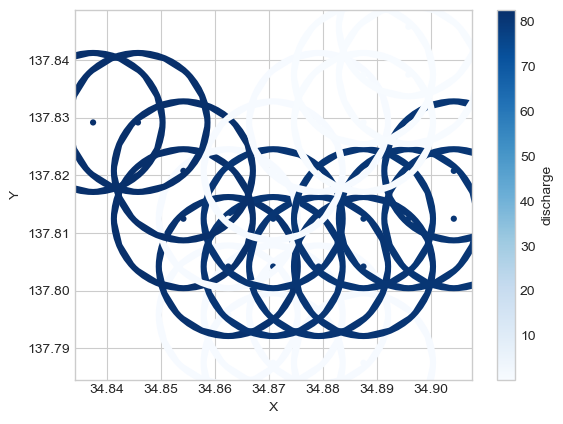

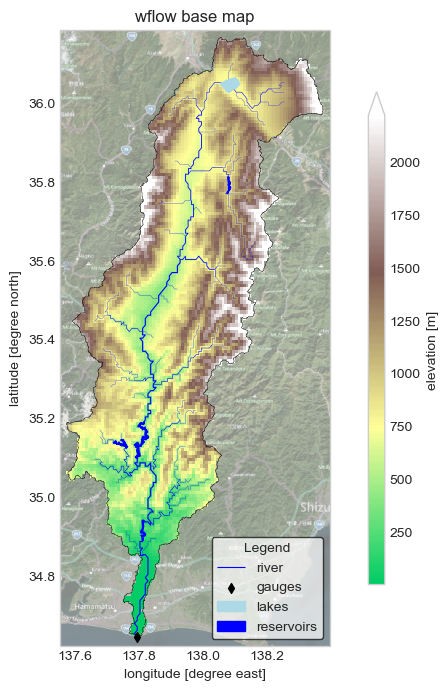

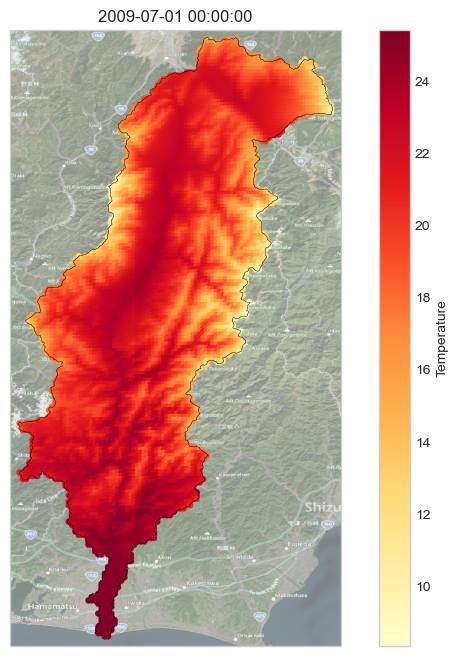

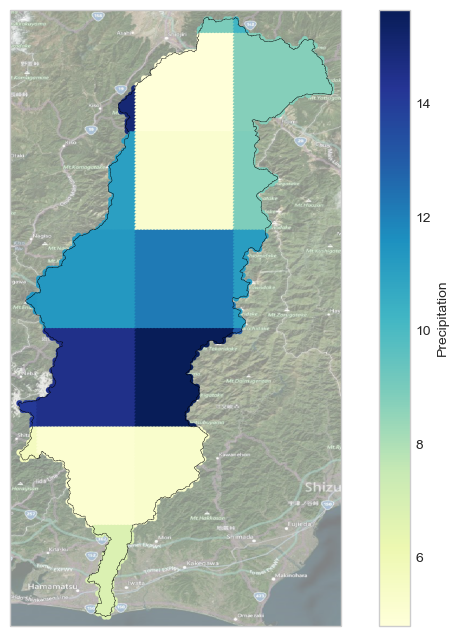

In [44]:
ds, coordinates, Ids, final_cors, long, data, mod, date_range = readFiles(timestepsecs, coordinate_path,nc_path,nc_name,root_path, refD)
Indices_Key_Area        = getCoordinates(SelectKeyArea, coordinates, final_cors)
Funagira_selection_WD, Funagira_selection_FV, Funagira_selection_Q, wd_reach, fv_reach, qr_reach =  processingData(Processes, SelectKeyArea, Ids, ds,final_cors, Indices_Key_Area, long)
Funagira_selection_WD, Funagira_selection_FV, Funagira_selection_Q, wd_reach, fv_reach, qr_reach =  processingData2(Processes, SelectKeyArea, Ids, ds,final_cors, Indices_Key_Area, long)
data = getStatistics(Indices_Key_Area, final_cors, Processes, SelectKeyArea, TS_Stats, output, Funagira_selection_WD, Funagira_selection_FV, Funagira_selection_Q, wd_reach, fv_reach, qr_reach)

plotParameters(mod, Plotting, data, Processes, SelectKeyArea, root_path, output)
plotParameters2(mod, Plotting, data, Processes, SelectKeyArea, root_path, output)
plotRiver(mod, output)
ds, SelectTS, final_cors, mod, output, long   = plorTemperature(root_path,nc_path, SelectTS, mod, date_range, output)
plotPrecipitation(ds, SelectTS, final_cors, mod, output, long)

In [45]:
#----------------------------------------------------------------------------
#-------------------ORIGINAL CODE-------------------------------------------

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): time(731), lon(96), lat(183), layer(4)
    variables(dimensions): float64 lon(lon), float64 lat(lat), float64 layer(layer), float64 time(time), float32 int(time, lat, lon), float32 river_width(time, lat, lon), float32 q_land(time, lat, lon), float32 q_river(time, lat, lon), float32 water_depth(time, lat, lon), float32 h_land(time, lat, lon), float32 precip(time, lat, lon)
    groups: 
{}
<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 731
<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 96
<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 183
<class 'netCDF4._netCDF4.Dimension'>: name = 'layer', size = 4
<class 'netCDF4._netCDF4.Variable'>
float64 lon(lon)
    _FillValue: nan
    long_name: longitude
    standard_name: longitude
    axis: X
    units: degrees_east
unlimited dimensions: 
current shape = (96,)
filling on
<class 'netCDF4._

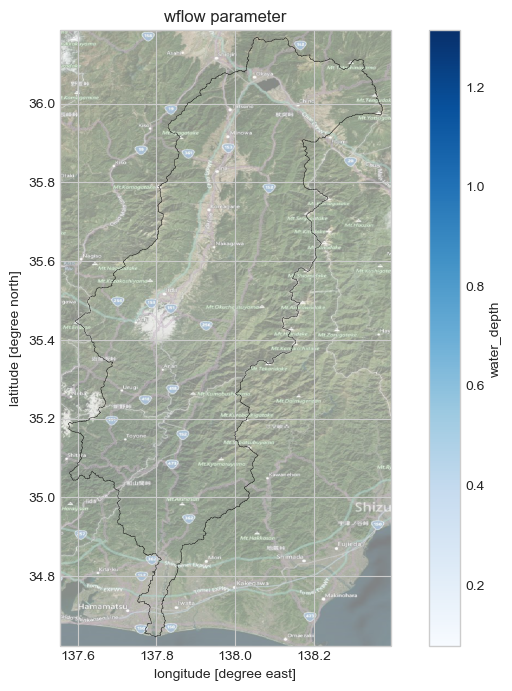

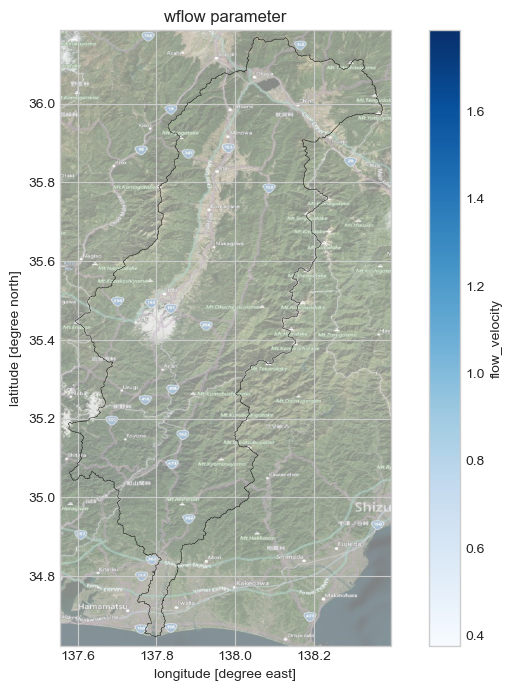

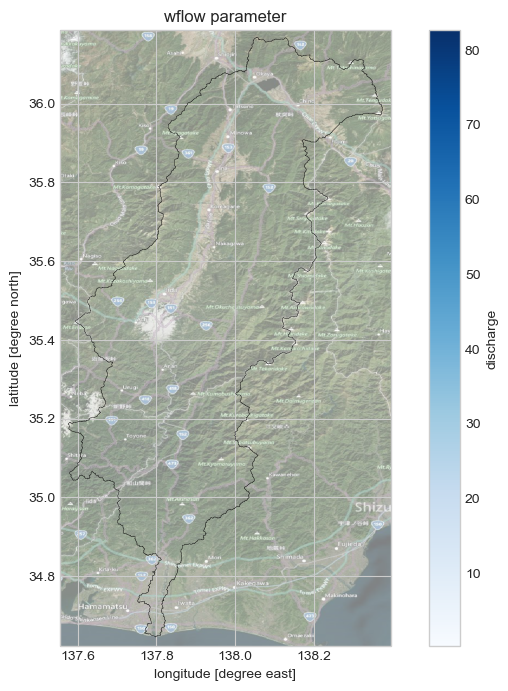

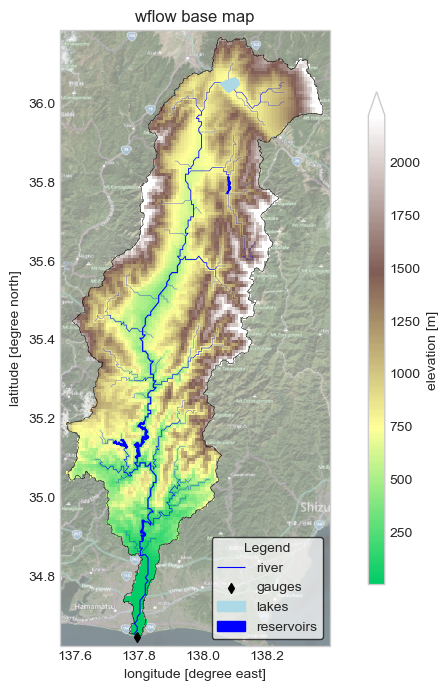

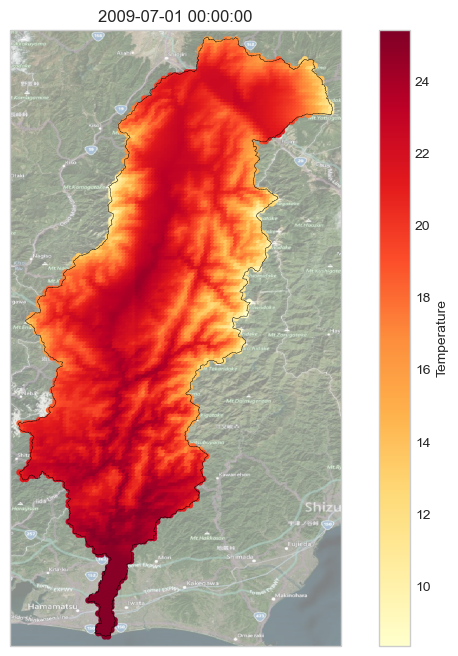

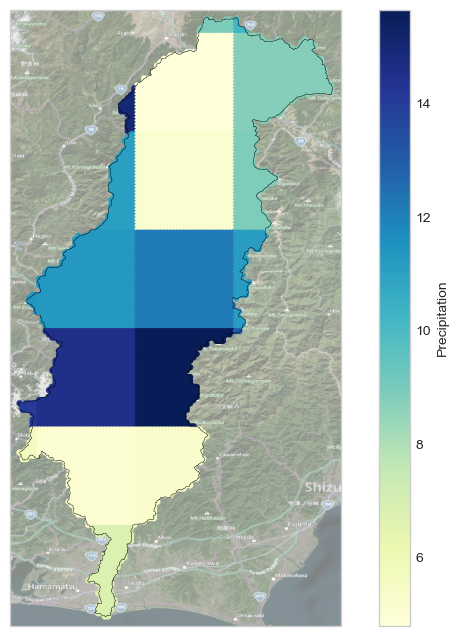

In [46]:
# -*- coding: utf-8 -*-
"""
Created on Wed Oct 27 13:43:20 2021

@author: oorschot

This is a script to extract data from Wflow simulations from nc-result files and write statistics and create figures 
"""

import os
import netCDF4 as nc
from netCDF4 import Dataset
import pandas as pd
import xarray as xr
import numpy as  np
from os.path import join, dirname
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors

import hydromt
from hydromt_wflow.wflow import WflowModel

# plot maps dependencies
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import descartes # required to plot polygons
import cartopy.io.img_tiles as cimgt
import datetime as datetime
import csv


#%% User defined settings
path = r"N:\Projects\11208000\11208005\F. Other information\025- EFlows\Manual\Tutorial files\wflow_model_updated"
root = r"N:\Projects\11208000\11208005\F. Other information\025- EFlows\Manual\Tutorial files\wflow_model_updated"
nc_name = 'output.nc'
output = r"output3"    # folder to write output files and figures
CoordinatePath =   r"N:\Projects\11208000\11208005\F. Other information\025- EFlows\Manual\Coordinates.csv"                      # list with coordinates to extract extent of model (if SelectKeyArea = True)
                                                          #[4966, 4967, 4968, 4969, 5149, 5153, 5330, 5331, 5332]

Plotting = True             # if false, no plots are created
SelectKeyArea = True        # if true, a set of coordinates has to be given from which the data is extracted. If false, the whole catchment is considered.

# specify wflow time input
timestepsecs = '86400'      # timestep in seconds. given in *.toml file
refD         = '19000101'   # reference date . given in *.toml file
TS_Stats     = 10           # user defined timestep to extract results for discharge, flow velocity and water depth On Day interval?
SelectTS     = 303          # user defined timestep for extracting results in static maps

# select the periods where you want to extract the data
Processes    = ['year2009']        # name of processes you want to extract
d = {'start': [122], 'end': [486]} #start dates and end dates within one process, see date_range for dates and corresponding index

# #%% User defined settings
# path = r"n:\Projects\11208000\11208005\F. Other information\025- EFlows\Manual\Tutorial files\wflow_model_updated"
# root = r"n:\Projects\11208000\11208005\F. Other information\025- EFlows\Manual\Tutorial files\wflow_model_updated"
# nc_name = 'output.nc'
# output = r"n:\Projects\11208000\11208005\F. Other information\025- EFlows\Manual\Tutorial files\wflow_model_updated\output" # folder to write output files and figures
# CoordinatePath =  r"n:\Projects\11208000\11208005\F. Other information\025- EFlows\Manual\coordinates.csv" # list with coordinates to extract extent of model (if SelectKeyArea = True)

# Plotting = True # if false, no plots are created
# SelectKeyArea = True # if true, a set of coordinates has to be given from which the data is extracted. If false, the whole catchment is considered.

# # specify wflow time input
# timestepsecs = '86400'  # timestep in seconds. given in *.toml file
# refD = '19000101' # reference date . given in *.toml file
# TS_Stats = 10 # user defined timestep to extract results for discharge, flow velocity and water depth 
# SelectTS = 303 # user defined timestep for extracting results in static maps

# # select the periods where you want to extract the data
# Processes = ['year2009'] # name of processes you want to extract
# d = {'start': [122], 'end': [486]} #start dates and end dates within one process, see date_range for dates and corresponding index


#%% load netcdf files and create dataframe with coordinates for plotting
coordinates = pd.read_csv(CoordinatePath,sep=';')
nc_file  = os.path.join(path, 'run_default', nc_name) # netcdf file met wflow output
mod = WflowModel(root, mode='r')
#indicesFunagira = # manually selected coordinate indices of area (TODO: replace by automated script from coordinate array)


ds = nc.Dataset(nc_file)
print(ds)
print(ds.__dict__)
for dim in ds.dimensions.values():
    print(dim)
for var in ds.variables.values():
    print(var)    

 
reference_date = datetime.datetime(int((refD[0:4])), int((refD[4:6])), int((refD[6:8])))        
# determine start end end dates
time = ds['time'][:]  
startdate = reference_date +datetime.timedelta(days=time[0])
enddate = reference_date +datetime.timedelta(days=time[len(time)-1]) 
timestep = timestepsecs + 'S' 
date_range = pd.date_range(start = startdate, end = enddate, freq = timestep)    

startDmdu = time[0]  # start date of simulation with reference to refD
endDmdu = time[len(time)-1]  # end date of simulation with reference to refD
TotalSimTime =   endDmdu - startDmdu

Ids = pd.DataFrame(data=d)

# extract coordinates
lat = ds['lat'][:] 
long = ds['lon'][:] 

cors = []
# create list of lat long coordinates in vector format
for i in range(len(long)):
    df1 = pd.DataFrame(lat)
    df2 = long[i]
    df2 = pd.DataFrame(np.repeat(df2, len(lat), axis=0))
    frames = [df1, df2]
    data = pd.concat(frames, axis = 1, ignore_index = True)    
    data.reset_index(drop=True, inplace=True)
    cors.append(data)
final_cors = pd.concat(cors, axis = 0, ignore_index = True)  
final_cors.rename(columns={0: 'Ycor', 1: 'Xcor'}, inplace=True)
final_cors = round(final_cors,4) # round coordinates to 4 decimals to match data from QGIS






#%% calculate statistics for water depth, discharge, flow velocity and write to *csv. file

if SelectKeyArea == True:
#check indices of coordinates for key area(s) of interest
#loop over coordinates to extract indices of coordinates that area within the key area
    Indices_Key_Area = []
    for x in range(len(coordinates)):
        Cors = coordinates.loc[x]
        SelectX  = final_cors[final_cors['Xcor'] == round(Cors.long,4)]            
        SelectY = SelectX[SelectX['Ycor'] == round(Cors.lat,4)]
        Idx = int(SelectY.index.values.astype(int)[0])
        Indices_Key_Area.append(Idx) # add index to list

for i in range(len(Processes)): # loop over number of processes
    process = Processes[i]
    dates = Ids.loc[i]
    start = dates.start # start ID of proces
    end = dates.end # end ID of proces
        
    # extract data of whole catchment
    rw = ds['river_width'][start:end,:,:]   # extract river width
    qr = ds['q_river'][start:end,:,:]   # extract river discharge
    wd = ds['water_depth'][start:end,:,:]    # extract water depth
    fv = qr/(rw*wd) # calculate flow velocity    

    # rw_av = np.median(rw, axis = 0)
    # qr_av = np.median(qr, axis = 0)
    # fv_av = np.median(fv, axis = 0)
    # wd_av = np.median(wd, axis = 0)
        
    # Data_wd = wd_av.data
    # Data_wd = pd.DataFrame(data=Data_wd)
    # Data_qr = qr_av.data
    # Data_qr = pd.DataFrame(data=Data_qr)
    # Data_fv = fv_av.data
    # Data_fv = pd.DataFrame(data=Data_fv)
    # Data_rw = rw_av.data
    # Data_rw = pd.DataFrame(data=Data_rw)

# add lat long data for funagira model reach per time step
    data_reach = []
    data_all = []
    for ts in range(end-start):
        data_all = []
        data_step = wd[ts,:,:]
        data_step = pd.DataFrame(data=data_step)
        for i in range(len(long)):
            df3 = pd.DataFrame(data_step[i])
            frames = [df3]
            data = pd.concat(frames, axis = 1, ignore_index = True)    
            data.reset_index(drop=True, inplace=True)
            data_all.append(data)
        wd_complete = pd.concat(data_all, axis = 0, ignore_index = True)     
        fr = [final_cors, wd_complete]
        data_fr = pd.concat(fr, axis = 1, ignore_index = True) 
        data_reach.append(data_fr)
    wd_reach = np.stack(data_reach)
    if SelectKeyArea == True:
        Funagira_selection_WD = wd_reach[:,Indices_Key_Area,:]
        #Funagira_selection_WD_1D = Funagira_selection_WD[:,:,2].reshape((end-start)*len(Indices_Key_Area), 1)

    data_reach = []
    data_all = []
    for ts in range(end-start):
        data_all = []
        data_step = fv[ts,:,:]
        data_step = pd.DataFrame(data=data_step)
        for i in range(len(long)):
            df3 = pd.DataFrame(data_step[i])
            frames = [df3]
            data = pd.concat(frames, axis = 1, ignore_index = True)    
            data.reset_index(drop=True, inplace=True)
            data_all.append(data)
        wd_complete = pd.concat(data_all, axis = 0, ignore_index = True)     
        fr = [final_cors, wd_complete]
        data_fr = pd.concat(fr, axis = 1, ignore_index = True) 
        data_reach.append(data_fr)
    fv_reach = np.stack(data_reach)
    if SelectKeyArea == True:
        Funagira_selection_FV = fv_reach[:,Indices_Key_Area,:]
        #Funagira_selection_FV_1D = Funagira_selection_FV[:,:,2].reshape((end-start)*len(Indices_Key_Area), 1)
 
    data_reach = []
    data_all = []
    for ts in range(end-start):
        data_all = []
        data_step = qr[ts,:,:]
        data_step = pd.DataFrame(data=data_step)
        for i in range(len(long)):
            df3 = pd.DataFrame(data_step[i])
            frames = [df3]
            data = pd.concat(frames, axis = 1, ignore_index = True)    
            data.reset_index(drop=True, inplace=True)
            data_all.append(data)
        wd_complete = pd.concat(data_all, axis = 0, ignore_index = True)     
        fr = [final_cors, wd_complete]
        data_fr = pd.concat(fr, axis = 1, ignore_index = True) 
        data_reach.append(data_fr)
    qr_reach = np.stack(data_reach)
    if SelectKeyArea == True:
        Funagira_selection_Q = qr_reach[:,Indices_Key_Area,:]
        #Funagira_selection_Q_1D = Funagira_selection_Q[:,:,2].reshape((end-start)*len(Indices_Key_Area), 1)    
 
    
# # add lat long data for whole catchment based on statistics 
#     data_all = []
#     for ts in range(end-start):
#         data_all = []
#         data_step = wd[ts,:,:]
#         data_step = pd.DataFrame(data=data_step)
        
#         for i in range(len(long)):
#             df3 = pd.DataFrame(data_step[i])
#             frames = [df3]
#             data = pd.concat(frames, axis = 1, ignore_index = True)    
#             data.reset_index(drop=True, inplace=True)
#             data_all.append(data)
#         wd_complete = pd.concat(data_all, axis = 0, ignore_index = True)     
#         fr = [final_cors, wd_complete]
        
#         wd_complete = np.stack(data_all)
#         #pd.concat(data_all, axis = 2, ignore_index = True)          
          
#     data_all = []
#     for i in range(len(long)):
#         df3 = pd.DataFrame(Data_qr[i])
#         frames = [df3]
#         data = pd.concat(frames, axis = 1, ignore_index = True)    
#         data.reset_index(drop=True, inplace=True)
#         data_all.append(data)
#     qr_complete = pd.concat(data_all, axis = 0, ignore_index = True)     
    
#     data_all = []
#     for i in range(len(long)):
#         df3 = pd.DataFrame(Data_fv[i])
#         frames = [df3]
#         data = pd.concat(frames, axis = 1, ignore_index = True)    
#         data.reset_index(drop=True, inplace=True)
#         data_all.append(data)
#     fv_complete = pd.concat(data_all, axis = 0, ignore_index = True) 
    
#     data_all = []
#     for i in range(len(long)):
#         df3 = pd.DataFrame(Data_rw[i])
#         frames = [df3]
#         data = pd.concat(frames, axis = 1, ignore_index = True)    
#         data.reset_index(drop=True, inplace=True)
#         data_all.append(data)
#     rw_complete = pd.concat(data_all, axis = 0, ignore_index = True) 
    
    
        

    if SelectKeyArea == True: # write statistics only of selected area at given coordinates
        # reset indices and select time step to save 
        coords = final_cors.loc[Indices_Key_Area] 
        coords.reset_index(drop=True, inplace = True)
        WD =  pd.DataFrame(Funagira_selection_WD[TS_Stats,:,2])
        WD.reset_index(drop=True, inplace = True)   
        FV =  pd.DataFrame(Funagira_selection_FV[TS_Stats,:,2])
        FV.reset_index(drop=True, inplace = True)  
        Q =  pd.DataFrame(Funagira_selection_Q[TS_Stats,:,2])
        Q.reset_index(drop=True, inplace = True)        
            
        frames = [coords, WD, FV, Q]
        data = pd.concat(frames, axis = 1, ignore_index = True)   
        data.rename(columns={0: 'X', 1:'Y', 2:'water_depth', 3:'flow_velocity', 4:'discharge'}, inplace=True)
        
        #export data Funagira to CSV file for comparison to Matlab
        nameCSV = 'Data_extent_' + process + '_ts_'+ str(TS_Stats) + '.csv'
        AllDataPath = os.path.join(output, nameCSV)  
        data.to_csv(AllDataPath, sep=';', mode="w", header=True, index=False)    
        
    else: # write statistics for whole model
        # reset indices and select time step to save 
        coords = final_cors 
        coords.reset_index(drop=True, inplace = True)
        WD =  pd.DataFrame(wd_reach[TS_Stats,:,2])
        WD.reset_index(drop=True, inplace = True)   
        FV =  pd.DataFrame(fv_reach[TS_Stats,:,2])
        FV.reset_index(drop=True, inplace = True)  
        Q =  pd.DataFrame(qr_reach[TS_Stats,:,2])
        Q.reset_index(drop=True, inplace = True)           
       
    
        frames = [final_cors, WD,  FV, Q]
        data = pd.concat(frames, axis = 1, ignore_index = True)     
        data.rename(columns={0: 'lat', 1: 'long', 2:'water_depth', 3:'flow_velocity', 4:'discharge',}, inplace=True)
        
        # Export data whole catchment to CSV file to use in e.g. QGIS 
        nameCSV = 'AllData_' + process + '_ts_' + str(TS_Stats) + '.csv'
        AllDataPath = os.path.join(output, nameCSV)  
        data.to_csv(AllDataPath, sep=';', mode="w", header=True, index=False)
        
        
        

    if Plotting == True:    
        colNames = list(data.columns)
        for j in range(3): # loop over parameters
            par = colNames[j+2]
            data_plot = data.iloc[:,[0,1,j+2]]
            data_plot = data_plot.replace(0, np.nan)
            
            # Plot data for proces    
            da =mod.staticmaps['wflow_dem'].raster.mask_nodata()
            da.attrs.update(long_name='elevation', units='m')
            # read/derive model basin boundary
            gdf_bas = mod.basins
            plt.style.use('seaborn-whitegrid') # set nice style
            # we assume the model maps are in the geographic CRS EPSG:4326
            proj = ccrs.PlateCarree()
            # adjust zoomlevel and figure size to your basis size & aspect
            zoom_level = 10
            figsize=(10, 8)       
                   
            # initialize image with geoaxes
            fig = plt.figure(figsize=figsize)
            ax = fig.add_subplot(projection=proj)
            extent = np.array(da.raster.box.buffer(0.02).total_bounds)[[0, 2, 1, 3]]
            ax.set_extent(extent, crs=proj)
            
            # add sat background image
            ax.add_image(cimgt.QuadtreeTiles(), zoom_level, alpha=0.5)
            if SelectKeyArea == True:
                data_plot.plot(x="X", y="Y", kind="scatter", ax = ax, c = par, colormap="Blues", linewidth = 0.1)
            else:
                data_plot.plot(x="long", y="lat", kind="scatter", ax = ax, c = par, colormap="Blues", linewidth = 0.1)
            
            # plot the basin boundary
            gdf_bas.boundary.plot(ax=ax, color='k', linewidth=0.3)
            
            ax.xaxis.set_visible(True)
            ax.yaxis.set_visible(True)
            ax.set_ylabel(f"latitude [degree north]")
            ax.set_xlabel(f"longitude [degree east]")
            _ = ax.set_title(f"wflow parameter")
            
            #  save figure and export data to csv for visualisation in QGIS
            figname = process + '_' + par
            figpath = os.path.join(output, figname)
            plt.savefig(figpath, dpi=225, bbox_inches="tight")



#%% Plot DEM with rivers, reservoirs, gauges and lakes
da =mod.staticmaps['wflow_dem'].raster.mask_nodata()
da.attrs.update(long_name='elevation', units='m')


# read/derive river geometries
gdf_riv = mod.rivers
# read/derive model basin boundary
gdf_bas = mod.basins


plt.style.use('seaborn-whitegrid') # set nice style
# we assume the model maps are in the geographic CRS EPSG:4326
proj = ccrs.PlateCarree()
# adjust zoomlevel and figure size to your basis size & aspect
zoom_level = 10
figsize=(10, 8)
shaded= False # shaded elevation (looks nicer with more pixels (e.g.: larger basins))!


# initialize image with geoaxes
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(projection=proj)
extent = np.array(da.raster.box.buffer(0.02).total_bounds)[[0, 2, 1, 3]]
ax.set_extent(extent, crs=proj)

# add sat background image
ax.add_image(cimgt.QuadtreeTiles(), zoom_level, alpha=0.5)

## plot elevation\
# create nice colormap
vmin, vmax = da.quantile([0.0, 0.98]).compute()
c_dem = plt.cm.terrain(np.linspace(0.25, 1, 256))
cmap = colors.LinearSegmentedColormap.from_list("dem", c_dem)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
kwargs = dict(cmap=cmap, norm=norm)
# plot 'normal' elevation
da.plot(transform=proj, ax=ax, zorder=1, cbar_kwargs=dict(aspect=30, shrink=.8), **kwargs)
# plot elevation with shades
if shaded:
    ls = colors.LightSource(azdeg=315, altdeg=45)
    dx, dy = da.raster.res
    _rgb = ls.shade(
        da.fillna(0).values,
        norm=kwargs["norm"],
        cmap=kwargs["cmap"],
        blend_mode="soft",
        dx=dx,
        dy=dy,
        vert_exag=200,
    )
    rgb = xr.DataArray(
        dims=("y", "x", "rgb"), data=_rgb, coords=da.raster.coords
    )
    rgb = xr.where(np.isnan(da), np.nan, rgb)
    rgb.plot.imshow(transform=proj, ax=ax, zorder=2)
                
# plot rivers with increasing width with stream order
kwargs = dict()
for strord in np.unique(gdf_riv['strord']):
    if strord == np.unique(gdf_riv['strord']).max():
        kwargs.update(label='river')
    gdf_riv[gdf_riv['strord']==strord].plot(ax=ax, linewidth=strord/5, color='blue', zorder=3, **kwargs)
# plot the basin boundary
gdf_bas.boundary.plot(ax=ax, color='k', linewidth=0.3)
# plot various vector layers if present
if 'gauges' in mod.staticgeoms:
    mod.staticgeoms['gauges'].plot(ax=ax, marker='d', markersize=25, facecolor='k', zorder=5, label='gauges')
patches = [] # manual patches for legend, see https://github.com/geopandas/geopandas/issues/660
if 'lakes' in mod.staticgeoms:
    kwargs = dict(facecolor='lightblue', edgecolor='lightblue', linewidth=1, label='lakes')
    mod.staticgeoms['lakes'].plot(ax=ax, zorder=4, **kwargs)
    patches.append(mpatches.Patch(**kwargs))
if 'reservoirs' in mod.staticgeoms:
    kwargs = dict(facecolor='blue', edgecolor='blue', linewidth=1, label='reservoirs')
    mod.staticgeoms['reservoirs'].plot(ax=ax, zorder=4, **kwargs)
    patches.append(mpatches.Patch(**kwargs))
if 'glaciers' in mod.staticgeoms:
    kwargs = dict(facecolor='grey', edgecolor='grey', linewidth=1, label='glaciers')
    mod.staticgeoms['glaciers'].plot(ax=ax, zorder=4, **kwargs)
    patches.append(mpatches.Patch(**kwargs))
    
ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)
ax.set_ylabel(f"latitude [degree north]")
ax.set_xlabel(f"longitude [degree east]")
_ = ax.set_title(f"wflow base map")
legend = ax.legend(
    handles=[*ax.get_legend_handles_labels()[0], *patches],
    title="Legend",
    loc='lower right',
    frameon=True,
    framealpha=0.7,
    edgecolor='k',
    facecolor='white'
)

# save figure
figname = "basemap.png"
figpath = os.path.join(output, figname)
plt.savefig(figpath, dpi=225, bbox_inches="tight")


#%% plot other static maps

nc_file = os.path.join(root, 'inmaps-chirps-2010.nc') # file with temperature and precipitation
nc_file2  = os.path.join(path, 'staticmaps.nc') # netcdf file met wflow output


# load and write parameters to plot in static data
ds = nc.Dataset(nc_file)
print(ds)
print(ds.__dict__)
for dim in ds.dimensions.values():
    print(dim)
for var in ds.variables.values():
    print(var) 

lat = ds['x'][:] 
long = ds['y'][:] 

#temp = ds['temp'][210,:,:]
# testing load nc file
#ds = nc.Dataset(era5_fn)
#print(ds)

cors = []
# create list of lat long coordinates in vector format
for i in range(len(long)):
    df1 = pd.DataFrame(lat)
    df2 = long[i]
    df2 = pd.DataFrame(np.repeat(df2, len(lat), axis=0))
    frames = [df1, df2]
    data = pd.concat(frames, axis = 1, ignore_index = True)    
    data.reset_index(drop=True, inplace=True)
    cors.append(data)
final_cors = pd.concat(cors, axis = 0, ignore_index = True)  
final_cors.rename(columns={0: 'lat', 1: 'long'}, inplace=True)


 


#%% Plot static data

#plot graph temperature
temp = ds['temp'][SelectTS,:,:]

data_all = []
for i in range(len(long)):
    df3 = pd.DataFrame(temp[i])
    frames = [df3]
    data = pd.concat(frames, axis = 1, ignore_index = True)    
    data.reset_index(drop=True, inplace=True)
    data_all.append(data)
rain_complete = pd.concat(data_all, axis = 0, ignore_index = True) 

frames = [final_cors, rain_complete]
data = pd.concat(frames, axis = 1, ignore_index = True)     
data.rename(columns={0: 'lat', 1: 'long', 2:'Temperature'}, inplace=True)


# Plot data for proces    
da =mod.staticmaps['wflow_dem'].raster.mask_nodata()
da.attrs.update(long_name='elevation', units='m')
# read/derive model basin boundary
gdf_bas = mod.basins
plt.style.use('seaborn-whitegrid') # set nice style
# we assume the model maps are in the geographic CRS EPSG:4326
proj = ccrs.PlateCarree()
# adjust zoomlevel and figure size to your basis size & aspect
zoom_level = 10
figsize=(10, 8)       
       
# initialize image with geoaxes
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(projection=proj)
extent = np.array(da.raster.box.buffer(0.02).total_bounds)[[0, 2, 1, 3]]
ax.set_extent(extent, crs=proj)

# add sat background image
ax.add_image(cimgt.QuadtreeTiles(), zoom_level, alpha=0.5)

data.plot(x="lat", y="long", kind="scatter", ax = ax, c = 'Temperature', colormap='YlOrRd', linewidth = 0.1)

# plot the basin boundary
gdf_bas.boundary.plot(ax=ax, color='k', linewidth=0.3)

sel_date = str(date_range[SelectTS])
_ = ax.set_title(sel_date)

figname = "Temperature"+ '_ts_' + str(SelectTS) + '.png'
figpath = os.path.join(output, figname)
plt.savefig(figpath, dpi=225, bbox_inches="tight")

#%% plot graph precipiation

rain = ds['precip'][SelectTS,:,:]

data_all = []
for i in range(len(long)):
    df3 = pd.DataFrame(rain[i])
    frames = [df3]
    data = pd.concat(frames, axis = 1, ignore_index = True)    
    data.reset_index(drop=True, inplace=True)
    data_all.append(data)
rain_complete = pd.concat(data_all, axis = 0, ignore_index = True) 

frames = [final_cors, rain_complete]
data = pd.concat(frames, axis = 1, ignore_index = True)     
data.rename(columns={0: 'lat', 1: 'long', 2:'Precipitation'}, inplace=True)


# Plot data for proces    
da =mod.staticmaps['wflow_dem'].raster.mask_nodata()
da.attrs.update(long_name='elevation', units='m')
# read/derive model basin boundary
gdf_bas = mod.basins
plt.style.use('seaborn-whitegrid') # set nice style
# we assume the model maps are in the geographic CRS EPSG:4326
proj = ccrs.PlateCarree()
# adjust zoomlevel and figure size to your basis size & aspect
zoom_level = 10
figsize=(10, 8)       
       
# initialize image with geoaxes
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(projection=proj)
extent = np.array(da.raster.box.buffer(0.02).total_bounds)[[0, 2, 1, 3]]
ax.set_extent(extent, crs=proj)

# add sat background image
ax.add_image(cimgt.QuadtreeTiles(), zoom_level, alpha=0.5)
data.plot(x="lat", y="long", kind="scatter", ax = ax, c = 'Precipitation', colormap="YlGnBu", linewidth = 0.1)

# plot the basin boundary
gdf_bas.boundary.plot(ax=ax, color='k', linewidth=0.3)


figname = "Precipitation"+ '_ts_' + str(SelectTS) + '.png'
figpath = os.path.join(output, figname)
plt.savefig(figpath, dpi=225, bbox_inches="tight")

